# Climate change project plan

The main goal of this project is to explore some open source planetary temperautre data in order to understand the planet's temperature trends of the past few centuries. The temperature dataset we use in this project originates from... source.... . The temperature data is estimated by .... and represents the the global earth temperatures and their aquisition uncertainties for the earth Land only regions and both Land and Ocean regions. 

Project summary: 
The first part of this data exploration project is defined by an initial exploration of the dataset and is followed by a visualisual analysis of the earth temperature measurements as function of time. The visualiy observed trend in earth temperature is explored in details in the second part of the project where we aim to simulate the existing data first and secondly to forecast the evolution of this trend in the 21th century. 

Table of content: 

* 1. Initial data exploration:
    * Loading dataset
    * Exploring the dataset
    * Engineering new dataset attributes
    * Earth's temperature seasonality
    * Earth's temperature time evolution 
    
* 2. Compring Earth's temperature forecasting using statistics and machine learning:
    * A. Forecasting time series using ARIMA model:
        * Converting data into a time series object
        * Selecting main candidate for time series forecasting with ARIMA model
            * Testing raw data time series for stationarity
            * Testing time series stationarity for differnet data transformations
            * Simulating existing "historical" data and forecasting
    * B. Forecasting time series using linear regression model:
        * Building a linear regression model using sklearn library
        * Computing the data fiting confidence intervals
        * Forecasting future earth's temperature trend 

## Import libraries and general details:

In [449]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3,10)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import datetime

# to make this notebook's output stable across runs
np.random.seed(42)

# Need to set the PROJ_LIB environment variable either before
# starting your notebook or in python with :
os.environ['PROJ_LIB'] = '''/Users/atsoc/miniconda3/envs/TensorVenv/share/proj'''

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mpl_toolkits.basemap import Basemap

# mpl.rcParams.update(mpl.rcParamsDefault) ## Reset the matplotlib style file to default

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "climate_change"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images" + '_' + PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok=True) # exist_ok avoid OSError error if directory exists already

def save_fig(figure_id, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, figure_id + "." + fig_extension)
    print("Saving figure:\"", figure_id, "\"")
    plt.savefig(path, format=fig_extension, dpi=resolution)

import pmdarima as pm

import scipy.stats as st
from scipy.stats import linregress

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA # from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 10, 6

## Initial data exploration:

Reading the data from a csv file into a Pandas DataFrame

In [345]:
data_global_temperatures = pd.read_csv('Data/GlobalTemperatures.csv')

List of columns available in the dataset. Each Temperature measurement column has a dedicated temperature unctainty column. 

In [346]:
data_raw_columns = data_global_temperatures.columns.to_list()
data_raw_columns

['dt',
 'LandAverageTemperature',
 'LandAverageTemperatureUncertainty',
 'LandMaxTemperature',
 'LandMaxTemperatureUncertainty',
 'LandMinTemperature',
 'LandMinTemperatureUncertainty',
 'LandAndOceanAverageTemperature',
 'LandAndOceanAverageTemperatureUncertainty']

As we can see below some data is missing for most of the columns. We would like to estimate the number of missing values in each of the columns.

In [347]:
data_global_temperatures.head(5)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [352]:
data_global_temperatures.isna().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

It looks like most of the temperature measurements columns are missing the same number of measurements (1200), we can easily check if these measurements correspond to the same time periods.

In [356]:
data_global_temperatures[['dt', 'LandMaxTemperature']][data_global_temperatures.LandMaxTemperature.isna()]

,dt,LandMaxTemperature
0,1750-01-01,NaN
1,1750-02-01,NaN
2,1750-03-01,NaN
3,1750-04-01,NaN
4,1750-05-01,NaN
...,...,...
1195,1849-08-01,NaN
1196,1849-09-01,NaN
1197,1849-10-01,NaN
1198,1849-11-01,NaN


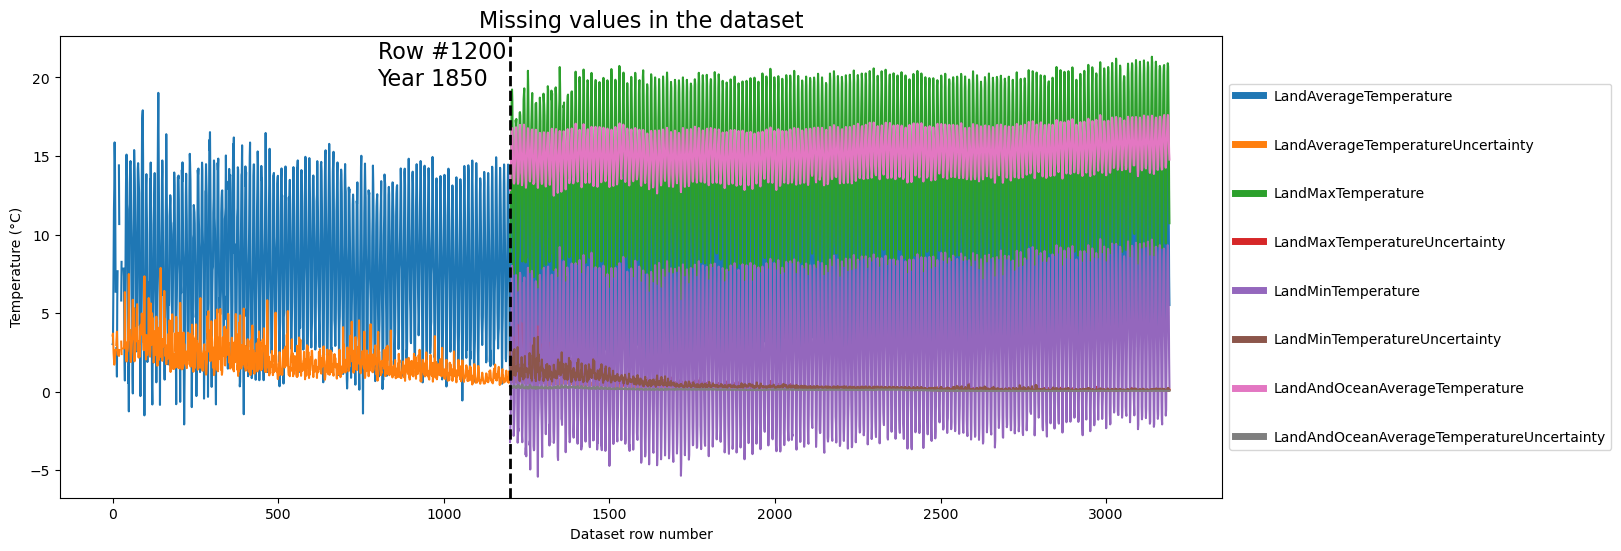

In [357]:
plt.figure(figsize=(15,6))
for column in data_raw_columns[1:]:
    plt.plot(data_global_temperatures[str(column)], label=str(column))
# plt.legend(loc='best')
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),labelspacing=2.5)

# change the line width for the legend
for line in legend.get_lines():
    line.set_linewidth(5)

plt.xlabel('Dataset row number')
plt.ylabel('Temperature (°C)')
plt.axvline(1200, color='black', ls='--', linewidth=2)
plt.title('Missing values in the dataset', fontsize=16)
plt.text(x=800, y = 19.5, s = 'Row #1200 \nYear 1850',fontsize=16)
plt.show()


We can clearly see on the graph above that most of the data is missing from 1750 to 1849, and a complete data is available from 1850 to 2015. This could be related to the less common temperature measurement in the 18th and first half of the 19th centurries. In the following data exploration analisys we will consider 1850 as the starting point of reliable temperature measurements.

#### Engineering new dataset attributes: Ocean average temperature
We can estimate the OceanAverageTemperature by substracting "LandAverageTemperature" from "LandAndOceanAverageTemperature"

In [358]:
data_global_temperatures["OceanAverageTemperature"] = data_global_temperatures["LandAndOceanAverageTemperature"] - data_global_temperatures["LandAverageTemperature"]
data_global_temperatures["OceanAverageTemperatureUncertainty"] = data_global_temperatures["LandAndOceanAverageTemperatureUncertainty"] + data_global_temperatures["LandAverageTemperatureUncertainty"]

#### Earth's temperature seasonality
We convert the dataframe dataset into a time series as it's easier to work with x-axis in terms of time. So we set the index to be the 'dt' column of the new timeseires dataframe

In [359]:
ts = data_global_temperatures[['dt', 'LandAndOceanAverageTemperature']]

In [360]:
data_seasonality = pd.DataFrame(ts['LandAndOceanAverageTemperature'].values, columns = ['LandAndOceanAverageTemperature'], index = pd.to_datetime(ts['dt']))
data_seasonality.index.freq = 'MS'
data_seasonality['month'] = data_seasonality.index.month
data_seasonality['year'] = data_seasonality.index.year

Saving figure:" Yearly temperature seasonality "


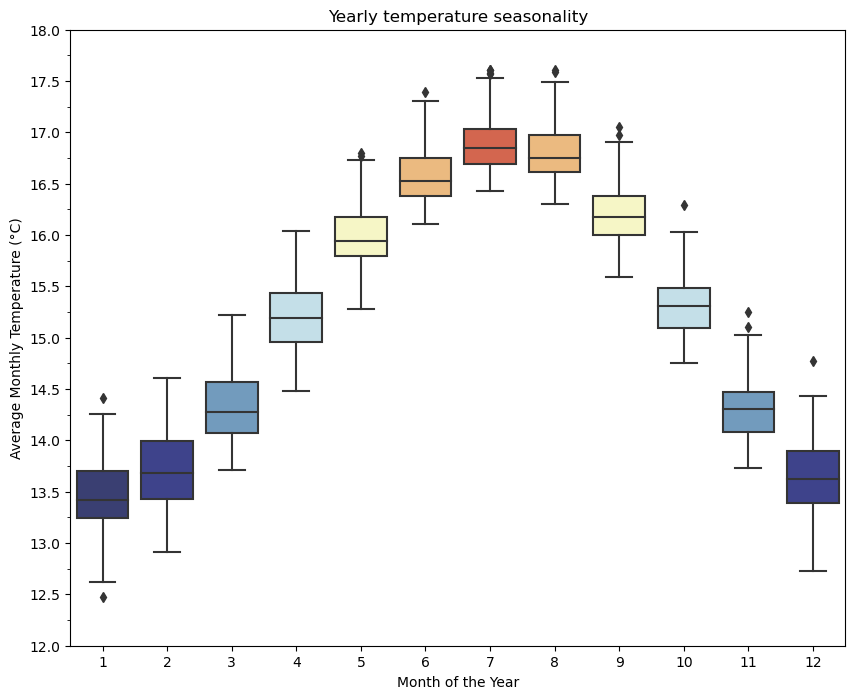

In [361]:
palette = ["#31387B", "#313898", "#669CC9", "#BEE2EE", "#FEFEBE", 
           "#FDBB6E", "#E95739", "#FDBB6E", "#FEFEBE", "#BEE2EE", 
           "#669CC9", "#313898"]
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data_seasonality, x='month', y='LandAndOceanAverageTemperature', palette=sns.color_palette(palette, 12))
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Average Monthly Temperature (°C)')
ax.set_title('Yearly temperature seasonality')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax.set_ylim([12,18])

save_fig("Yearly temperature seasonality")

plt.show()

There is a clear seasonality trend in the data, we see for instance that summer months 6 to 8 the temperature is at it's highest, whereas in the winter months the temperature is considerably falling down. The range of tmeperatures between summer and winter is about 4 degrees celcius.

#### Earth's temperature time evolution 
Add y-axis minor tickes and also implement a color palette to the box plots. Color should be proportional to the temperature value. 

In [362]:
def yearly_temperature_calculation(dataset): 
    dataset_columns =  dataset.columns.to_list()
    yearly_columns = ['Year'] + ['Yearly' + column for column in dataset_columns[1:]]

    yearly_dataset = pd.DataFrame(columns=yearly_columns)

    for year in range(1750, 2015 + 1, 1):
            yearly_dataset.loc[year,['Year']] = year

    for i in range(1,len(yearly_columns),1):
        for year in range(1750, 2015 + 1, 1):
            yearly_dataset.loc[year,[yearly_columns[i]]] = dataset[dataset['dt'].str.contains(str(year))][dataset_columns[i]].mean()

    yearly_dataset = yearly_dataset.astype(float)
    yearly_dataset['Year'] = yearly_dataset['Year'].astype(int)
    return yearly_dataset

data_global_yearly_temperatures = yearly_temperature_calculation(data_global_temperatures)

In [363]:
data_global_yearly_temperatures

,Year,YearlyLandAverageTemperature,YearlyLandAverageTemperatureUncertainty,YearlyLandMaxTemperature,YearlyLandMaxTemperatureUncertainty,YearlyLandMinTemperature,YearlyLandMinTemperatureUncertainty,YearlyLandAndOceanAverageTemperature,YearlyLandAndOceanAverageTemperatureUncertainty,YearlyOceanAverageTemperature,YearlyOceanAverageTemperatureUncertainty
1750,1750,8.719364,2.637818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1751,1751,7.976143,2.781143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1752,5.779833,2.977000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1753,1753,8.388083,3.176000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1754,1754,8.469333,3.494250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2011,2011,9.516000,0.082000,15.284833,0.114333,3.827667,0.136583,15.769500,0.059000,6.253500,0.141000
2012,2012,9.507333,0.083417,15.332833,0.107333,3.756167,0.145333,15.802333,0.061500,6.295000,0.144917
2013,2013,9.606500,0.097667,15.373833,0.115500,3.911333,0.149833,15.854417,0.064667,6.247917,0.162333
2014,2014,9.570667,0.090167,15.313583,0.111667,3.877750,0.139000,15.913000,0.063167,6.342333,0.153333


Saving figure:" Earth yearly temperature trends "


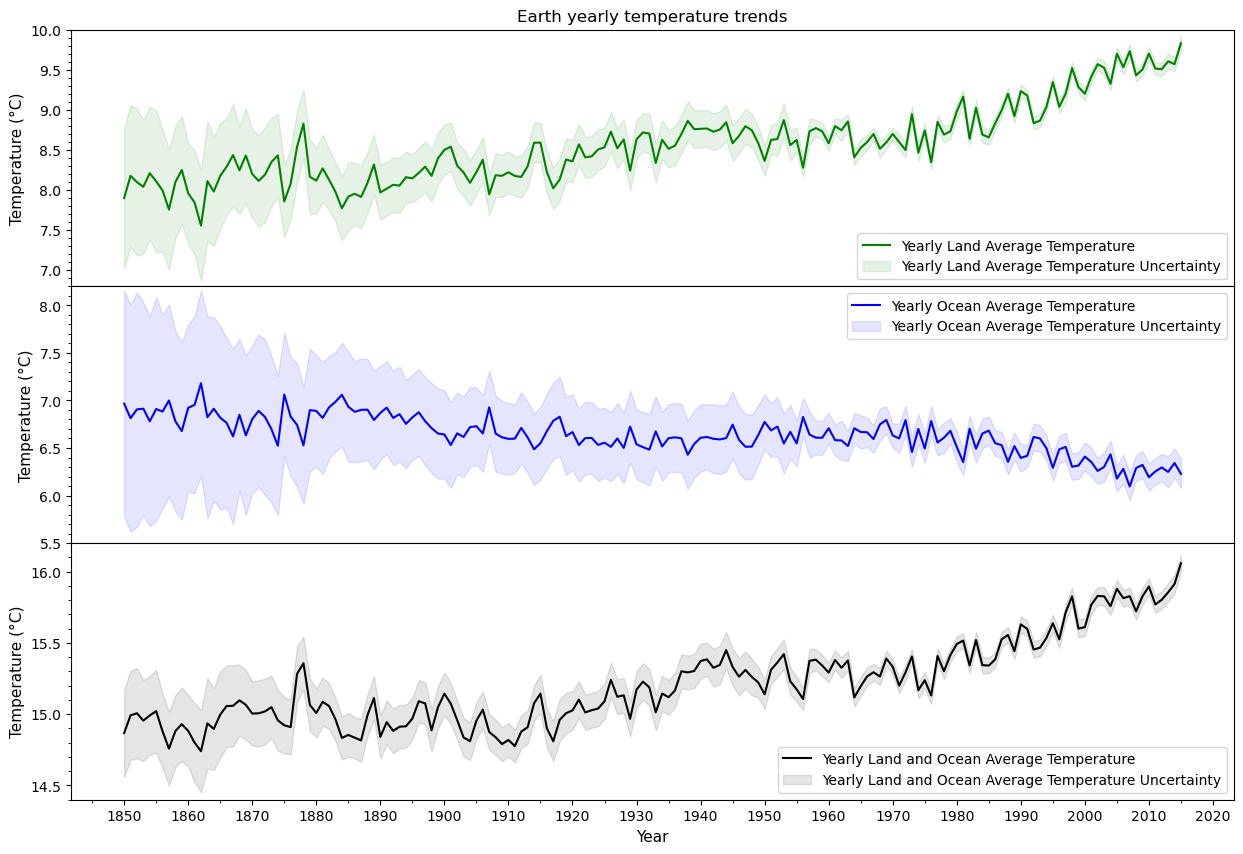

In [364]:
beginning_year, end_year = 1850, 2015

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15, 10))

fig.subplots_adjust(hspace=0)

ax1.plot(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year],data_global_yearly_temperatures['YearlyLandAverageTemperature'].loc[beginning_year:end_year],'g', label='Yearly Land Average Temperature')
ax1.fill_between(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyLandAverageTemperature'].loc[beginning_year:end_year] - data_global_yearly_temperatures['YearlyLandAverageTemperatureUncertainty'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyLandAverageTemperature'].loc[beginning_year:end_year] + data_global_yearly_temperatures['YearlyLandAverageTemperatureUncertainty'].loc[beginning_year:end_year], alpha=0.1, edgecolor='g', facecolor='g',label='Yearly Land Average Temperature Uncertainty')
ax1.set_ylim([6.8,10])
ax1.legend(loc='lower right')
ax1.set_ylabel('Temperature (°C)', fontsize=11)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax1.set_title('Earth yearly temperature trends',fontsize=12)

ax2.plot(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year],data_global_yearly_temperatures['YearlyOceanAverageTemperature'].loc[beginning_year:end_year],'b',label='Yearly Ocean Average Temperature')
ax2.fill_between(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyOceanAverageTemperature'].loc[beginning_year:end_year] - data_global_yearly_temperatures['YearlyOceanAverageTemperatureUncertainty'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyOceanAverageTemperature'].loc[beginning_year:end_year] + data_global_yearly_temperatures['YearlyOceanAverageTemperatureUncertainty'].loc[beginning_year:end_year], alpha=0.1, edgecolor='b', facecolor='b', label='Yearly Ocean Average Temperature Uncertainty')
ax2.set_ylim([5.5,8.2])
ax2.legend(loc='best')
ax2.set_ylabel('Temperature (°C)', fontsize=11)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax3.plot(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year],data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[beginning_year:end_year],'k',label='Yearly Land and Ocean Average Temperature')
ax3.fill_between(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[beginning_year:end_year] - data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperatureUncertainty'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[beginning_year:end_year] + data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperatureUncertainty'].loc[beginning_year:end_year], alpha=0.1, edgecolor='k', facecolor='k',label='Yearly Land and Ocean Average Temperature Uncertainty')
ax3.set_ylim([14.4,16.2])
ax3.legend(loc='lower right')
ax3.set_xlabel('Year', fontsize=11)
ax3.set_ylabel('Temperature (°C)', fontsize=11)

ax3.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax3.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
save_fig("Earth yearly temperature trends")
plt.show()

From the above figure it's clear that the earth's tempreature has a positive increasing trend. This trend is especially pronounced in the 20th century. Let's visualize the temperature evolution in comparison yo the 1951-1980 region temperautres. This will enable us to visualy see the temperature change in the past 200 years.

In [365]:
global_Yearly_temperature_1951_1980_avg = data_global_yearly_temperatures.loc[1951:1980,['YearlyLandAndOceanAverageTemperature']].mean()[0]
print('The average yearly temperature between 1951-1980 is ',round(global_Yearly_temperature_1951_1980_avg,2),'°C', sep='')

The average yearly temperature between 1951-1980 is 15.3°C


In [366]:
data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[1850:].values

array([14.86716667, 14.99183333, 15.0065    , 14.95516667, 14.991     ,
       15.02108333, 14.87933333, 14.75825   , 14.8815    , 14.92991667,
       14.88291667, 14.80066667, 14.74008333, 14.93575   , 14.8965    ,
       14.99666667, 15.057     , 15.05866667, 15.09691667, 15.0655    ,
       15.00433333, 15.00591667, 15.01933333, 15.04925   , 14.957     ,
       14.92191667, 14.90941667, 15.28266667, 15.35741667, 15.06441667,
       15.00866667, 15.08716667, 15.05658333, 14.96325   , 14.83325   ,
       14.85441667, 14.83525   , 14.816     , 14.99408333, 15.11341667,
       14.84075   , 14.94383333, 14.8825    , 14.91225   , 14.91475   ,
       14.969     , 15.09058333, 15.07533333, 14.88691667, 15.04833333,
       15.14391667, 15.07333333, 14.95833333, 14.83658333, 14.81041667,
       14.95466667, 15.03191667, 14.87483333, 14.83816667, 14.79033333,
       14.81908333, 14.776     , 14.87716667, 14.90875   , 15.07625   ,
       15.14375   , 14.90133333, 14.80975   , 14.95983333, 15.00

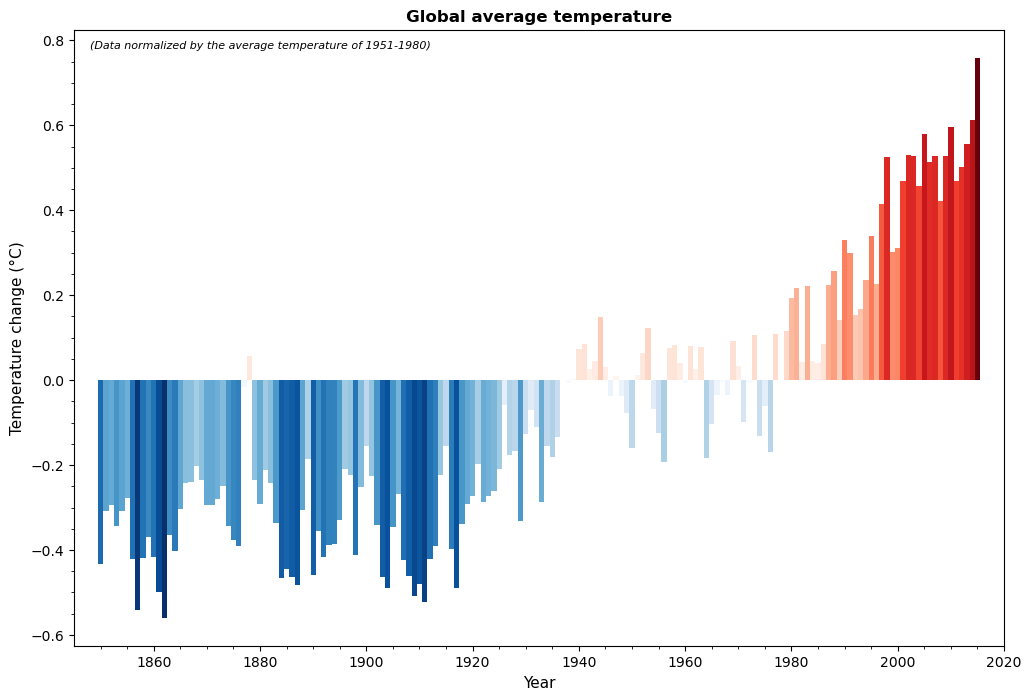

In [367]:
pos_cmap = plt.get_cmap("Reds")
neg_cmap = plt.get_cmap("Blues_r")

x = data_global_yearly_temperatures['Year'].loc[1850:]
y = data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[1850:]-global_Yearly_temperature_1951_1980_avg

positive_mask = y > 0
negative_mask = y <= 0

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.figure(figsize=(12, 8))
plt.tight_layout()
plt.bar(x[positive_mask], y[positive_mask], width=1, color=pos_cmap(rescale(y[positive_mask])), linewidth=0.01)
plt.bar(x[negative_mask], y[negative_mask], width=1, color=neg_cmap(rescale(y[negative_mask])), linewidth=0.01)
plt.xlabel('Year', fontsize = 11)
plt.xlim([1845,2020])
plt.ylabel('Temperature change (°C)', fontsize = 11)
plt.title('Global average temperature', fontsize=12, fontweight="bold")
plt.text(x=1848, y = 0.78, s = '(Data normalized by the average temperature of 1951-1980)',fontsize=8, style='italic')
plt.minorticks_on()
plt.show()

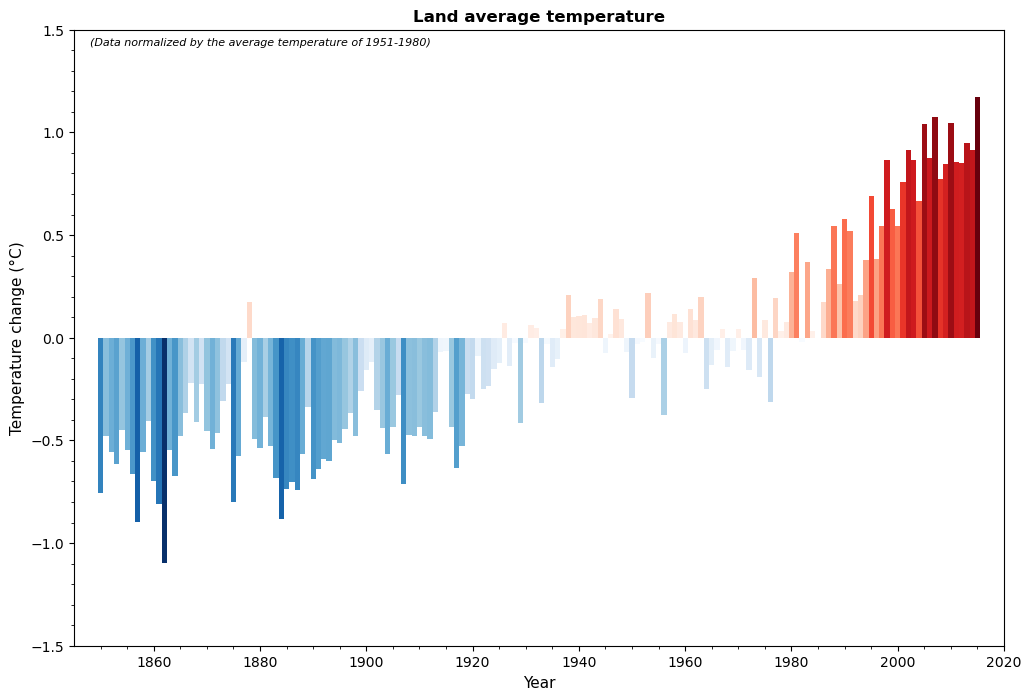

In [368]:
land_Yearly_temperature_1951_1980_avg = data_global_yearly_temperatures.loc[1951:1980,['YearlyLandAverageTemperature']].mean()[0]

pos_cmap = plt.get_cmap("Reds")
neg_cmap = plt.get_cmap("Blues_r")

x = data_global_yearly_temperatures['Year'].loc[1850:]
y = data_global_yearly_temperatures['YearlyLandAverageTemperature'].loc[1850:]-land_Yearly_temperature_1951_1980_avg

positive_mask = y > 0
negative_mask = y <= 0

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.figure(figsize=(12, 8))
plt.tight_layout()
plt.bar(x[positive_mask], y[positive_mask], width=1, color=pos_cmap(rescale(y[positive_mask])), linewidth=0.01)
plt.bar(x[negative_mask], y[negative_mask], width=1, color=neg_cmap(rescale(y[negative_mask])), linewidth=0.01)
plt.xlabel('Year', fontsize = 11)
plt.ylabel('Temperature change (°C)', fontsize = 11)
plt.xlim([1845,2020])
plt.ylim([-1.5,1.5])
plt.title('Land average temperature', fontsize=12, fontweight="bold")
plt.text(x=1848, y = 1.425, s = '(Data normalized by the average temperature of 1951-1980)',fontsize=8, style='italic')
plt.minorticks_on()
plt.show()

## Compring Earth's temperature forecasting using statistics and machine learning:
The ARIMA (AutoRegressive Integrated Moving Average) model is a class of statistical models for analyzing and forecasting time series data. 
* AR: AutoEegression - A model that uses the dependent relationship between an observation and some number of lagged observations.
    * p: The number of lag observations included in the model, also called the lag order.
* I: Integrated - The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
    * d: The number of times that the raw observations are differenced, also called the degree of differencing.
* MA: Moving Average - A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
    * q: The size of the moving average window, also called the order of moving average.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

### Converting data to time series

In [450]:
starting_dataset_date = 1850
final_dataset_date = 2015
index_starting_dataset_date = data_global_temperatures['dt'].str.contains(str(starting_dataset_date)).idxmax()
index_final_dataset_date = data_global_temperatures.dt.size

In [372]:
ts = data_global_temperatures[['dt', 'LandAndOceanAverageTemperature']]

In [373]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dt                              3192 non-null   object 
 1   LandAndOceanAverageTemperature  1992 non-null   float64
dtypes: float64(1), object(1)
memory usage: 50.0+ KB


In [374]:
data_temperature_ts = pd.Series(ts['LandAndOceanAverageTemperature'][index_starting_dataset_date:index_final_dataset_date].values, index = pd.to_datetime(ts['dt'][index_starting_dataset_date:index_final_dataset_date]))

In [375]:
data_temperature_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1992 entries, 1850-01-01 to 2015-12-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
1992 non-null   float64
dtypes: float64(1)
memory usage: 31.1 KB


We perform rolling mean and standard deviation to the monthly time series data:

In [377]:
rolmean = data_temperature_ts.rolling(window=12).mean()
rolstd = data_temperature_ts.rolling(window=12).std()

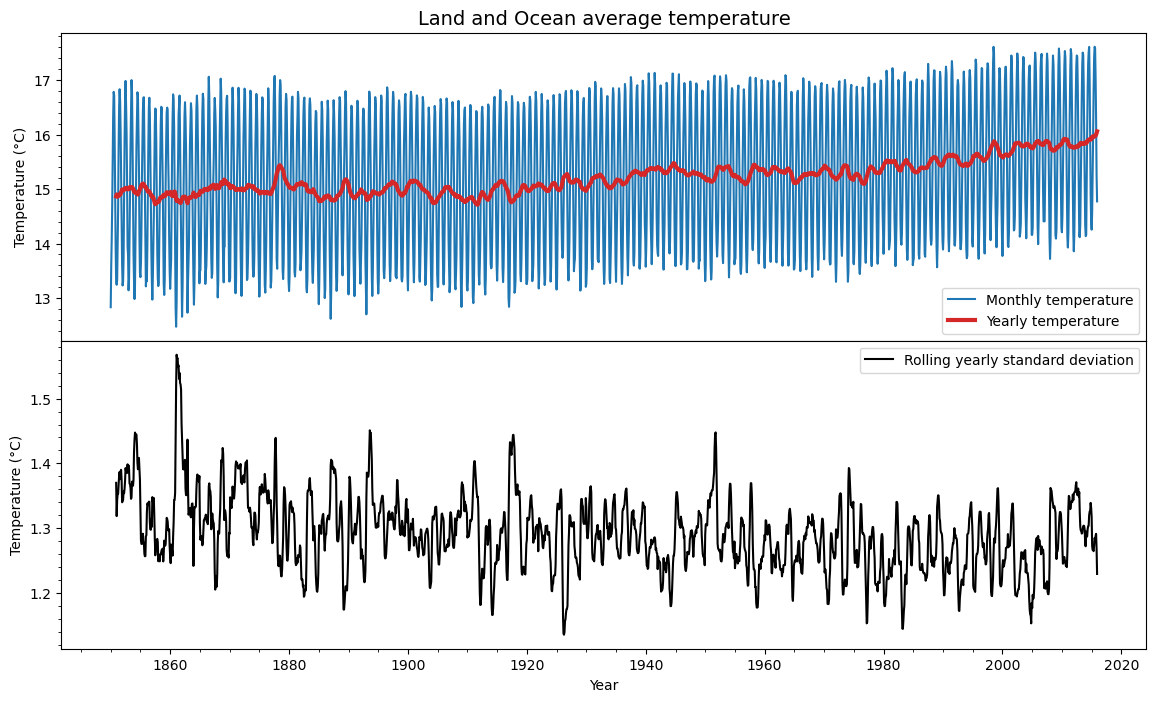

In [452]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14,8))
fig.subplots_adjust(hspace=0)

ax1.set_title('Land and Ocean average temperature', fontsize=14)
ax1.plot(data_temperature_ts, color='tab:blue', label='Monthly temperature')
ax1.plot(rolmean, color='tab:red', label='Yearly temperature', linewidth=3)
ax1.legend(loc='best')
ax1.set_ylabel('Temperature (°C)')
ax1.minorticks_on() 

ax2.plot(rolstd, color='k', label='Rolling yearly standard deviation')
ax2.set_xlabel('Year')
ax2.legend(loc='best')
ax2.set_ylabel('Temperature (°C)')
ax2.minorticks_on()

plt.show()

From the above graphs, we see that rolling mean itself has a trend component even though rolling standard deviation is constant with time.

In [379]:
def adfuller_critical_values(dataset):

    dftest = adfuller(dataset, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    return dfoutput

In [380]:
adfuller_result_rawdata = adfuller_critical_values(data_temperature_ts)
print('Adfuller result of Raw Data:','\n',adfuller_result_rawdata, sep='')

Adfuller result of Raw Data:
Test Statistic                   -1.135299
p-value                           0.700792
#Lags Used                       26.000000
Number of Observations Used    1965.000000
Critical Value (1%)              -3.433682
Critical Value (5%)              -2.863012
Critical Value (10%)             -2.567554
dtype: float64


For a Time series to be stationary, its ADCF test should have:

p-value to be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

#### Data Transformation to achieve Stationarity 
There are a couple of ways to achieve stationarity through data transformation like taking  log10 , loge , square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

In [381]:
# Log Scale Transformation
indexedDataset_logscale = np.log1p(data_temperature_ts)

In [461]:
data_temperature_ts

dt
1850-01-01    12.833
1850-02-01    13.588
1850-03-01    14.043
1850-04-01    14.667
1850-05-01    15.507
               ...  
2015-08-01    17.589
2015-09-01    17.049
2015-10-01    16.290
2015-11-01    15.252
2015-12-01    14.774
Freq: MS, Length: 1992, dtype: float64

In [463]:
SARIMA_model = pm.auto_arima(data_temperature_ts,
    start_p=1, start_q=1,
    test='adf',
    max_p=4, max_q=4, 
    m=12, #12 is the frequncy of the cycle
    start_P=0, 
    seasonal=True, #set to seasonal
    d=None, 
    D=1, #order of the seasonal differencing
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True, )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-837.953, Time=0.25 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-2204.786, Time=3.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-2284.318, Time=3.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-837.257, Time=0.14 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-1366.734, Time=0.33 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-2286.324, Time=4.37 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-1850.309, Time=2.52 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-2285.096, Time=18.38 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-2284.833, Time=21.17 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-2286.120, Time=16.01 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-2019.790, Time=7.28 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=-2283.633, Time=21.07 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-1626.524, Time=3.24 sec
 ARIMA(1,

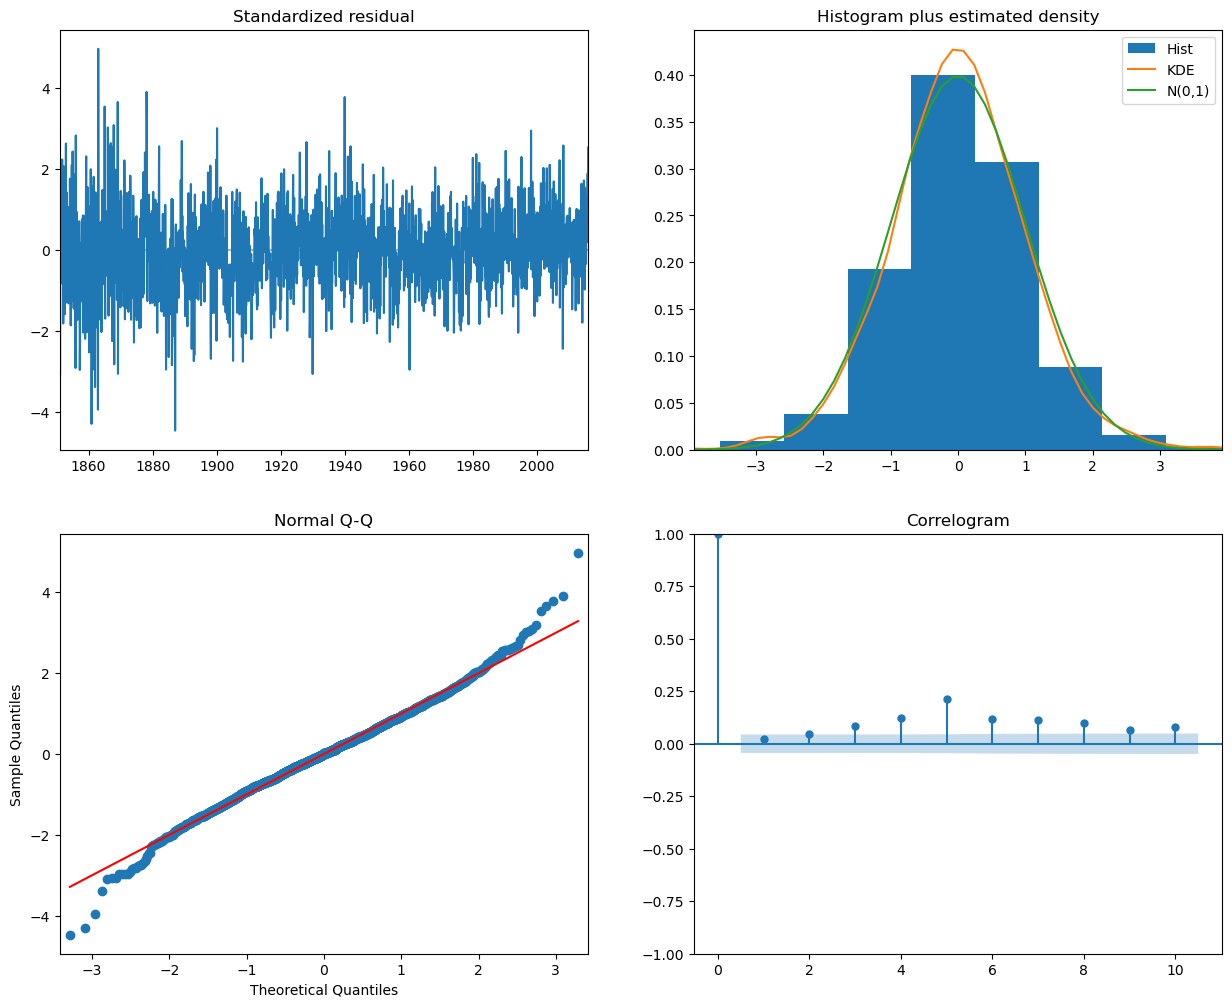

In [475]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [543]:
def model_forecast_plot(model, dataset, forecast_periods):
    # Forecasting model for a given number of years
    fitted, confint = model.predict(n_periods = forecast_periods, return_conf_int = True, alpha=0.05)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(dataset, color='#1f76b4', label='Historical earth global temperature')
    plt.plot(fitted.index, fitted, color='darkgreen', label='Forecasted earth global temperature')
    plt.fill_between(fitted.index, 
                    confint[:, 0], 
                    confint[:, 1], 
                    color='k', alpha=.15,
                    label='Confidence interval of forecast: 95%')

    plt.title("Earth global temperature: historical data and forecast")
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Year')
    plt.minorticks_on()
    plt.legend(loc='upper left')
    plt.show()

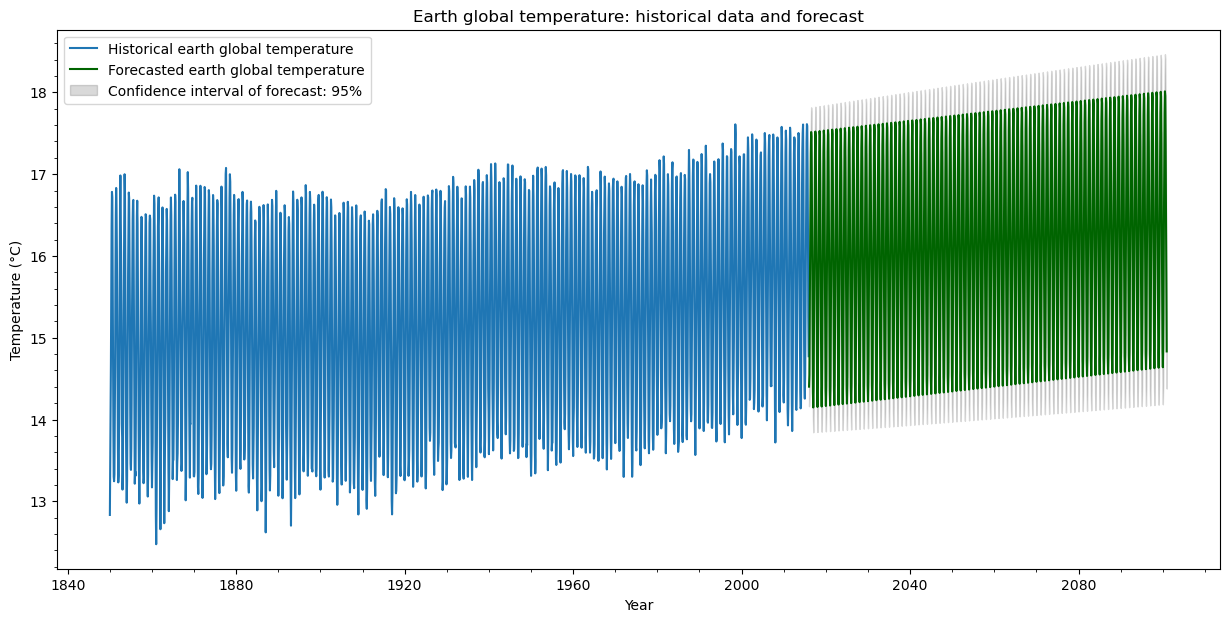

In [544]:
model_forecast_plot(SARIMA_model,data_temperature_ts, 85*12)

In [382]:
#The below transformation is required to make series stationary
rolmean_logscale = indexedDataset_logscale.rolling(window=12).mean()
rolstd_logscale = indexedDataset_logscale.rolling(window=12).std()

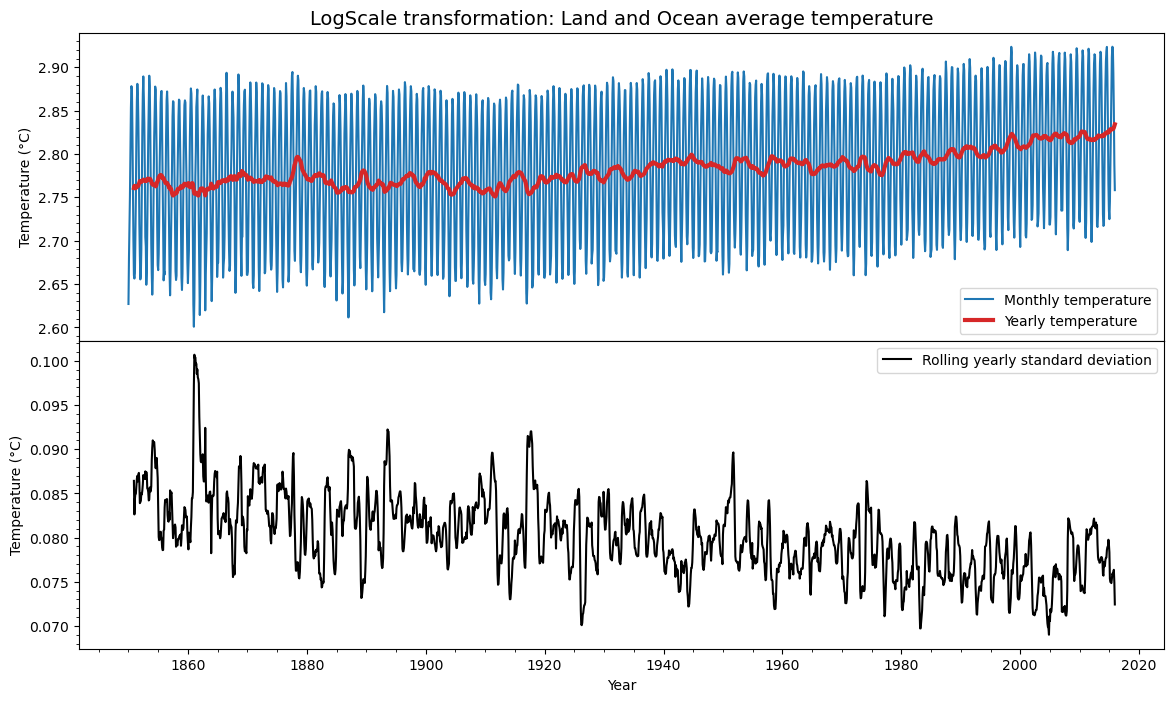

In [383]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14,8))
fig.subplots_adjust(hspace=0)


ax1.set_title('LogScale transformation: Land and Ocean average temperature', fontsize=14)
ax1.plot(indexedDataset_logscale, color='tab:blue', label='Monthly temperature')
ax1.plot(rolmean_logscale, color='tab:red', label='Yearly temperature', linewidth=3)
ax1.legend(loc='best')
ax1.set_ylabel('Temperature (°C)')
ax1.minorticks_on() 

ax2.plot(rolstd_logscale, color='k', label='Rolling yearly standard deviation')
ax2.set_xlabel('Year')
ax2.legend(loc='best')
ax2.set_ylabel('Temperature (°C)')
ax2.minorticks_on()

plt.show()

In [384]:
adfuller_result_logscale = adfuller_critical_values(indexedDataset_logscale)
print('Adfuller result of Log scale transformation data:','\n',adfuller_result_logscale, sep='')

Adfuller result of Log scale transformation data:
Test Statistic                   -1.230499
p-value                           0.660340
#Lags Used                       26.000000
Number of Observations Used    1965.000000
Critical Value (1%)              -3.433682
Critical Value (5%)              -2.863012
Critical Value (10%)             -2.567554
dtype: float64


In [385]:
indexedDataset_sqrt = np.sqrt(data_temperature_ts)
adfuller_result_sqrt = adfuller_critical_values(indexedDataset_sqrt)
print('Adfuller result of square root scale transformation data:','\n',adfuller_result_sqrt, sep='')

Adfuller result of square root scale transformation data:
Test Statistic                   -1.185153
p-value                           0.679950
#Lags Used                       26.000000
Number of Observations Used    1965.000000
Critical Value (1%)              -3.433682
Critical Value (5%)              -2.863012
Critical Value (10%)             -2.567554
dtype: float64


In [386]:
indexedDataset_diff = data_temperature_ts.diff().dropna()
adfuller_result_diff = adfuller_critical_values(indexedDataset_diff)
print('Adfuller result of differentiated transformation data:','\n',adfuller_result_diff, sep='')

Adfuller result of differentiated transformation data:
Test Statistic                -1.179241e+01
p-value                        9.755605e-22
#Lags Used                     2.500000e+01
Number of Observations Used    1.965000e+03
Critical Value (1%)           -3.433682e+00
Critical Value (5%)           -2.863012e+00
Critical Value (10%)          -2.567554e+00
dtype: float64


In [387]:
indexedDataset_diff_year = data_temperature_ts.diff(12).dropna()
adfuller_result_diff_year = adfuller_critical_values(indexedDataset_diff_year)
print('Adfuller result of 12 month differentiated transformation data:','\n',adfuller_result_diff_year, sep='')

Adfuller result of 12 month differentiated transformation data:
Test Statistic                -1.198809e+01
p-value                        3.573912e-22
#Lags Used                     2.400000e+01
Number of Observations Used    1.955000e+03
Critical Value (1%)           -3.433699e+00
Critical Value (5%)           -2.863020e+00
Critical Value (10%)          -2.567558e+00
dtype: float64


In [388]:
indexedDataset_sqrt = np.sqrt(data_temperature_ts)
adfuller_result_sqrt = adfuller_critical_values(indexedDataset_sqrt)
print('Adfuller result of square root scale transformation data:','\n',adfuller_result_sqrt, sep='')

Adfuller result of square root scale transformation data:
Test Statistic                   -1.185153
p-value                           0.679950
#Lags Used                       26.000000
Number of Observations Used    1965.000000
Critical Value (1%)              -3.433682
Critical Value (5%)              -2.863012
Critical Value (10%)             -2.567554
dtype: float64


In [389]:
indexedDataset_untrended = (data_temperature_ts - data_temperature_ts.rolling(window=12).mean()).dropna()
adfuller_result_untrended = adfuller_critical_values(indexedDataset_untrended)
print('Adfuller result of raw data minus the trend:','\n',adfuller_result_untrended, sep='')

Adfuller result of raw data minus the trend:
Test Statistic                -1.191489e+01
p-value                        5.192694e-22
#Lags Used                     2.600000e+01
Number of Observations Used    1.954000e+03
Critical Value (1%)           -3.433701e+00
Critical Value (5%)           -2.863020e+00
Critical Value (10%)          -2.567558e+00
dtype: float64


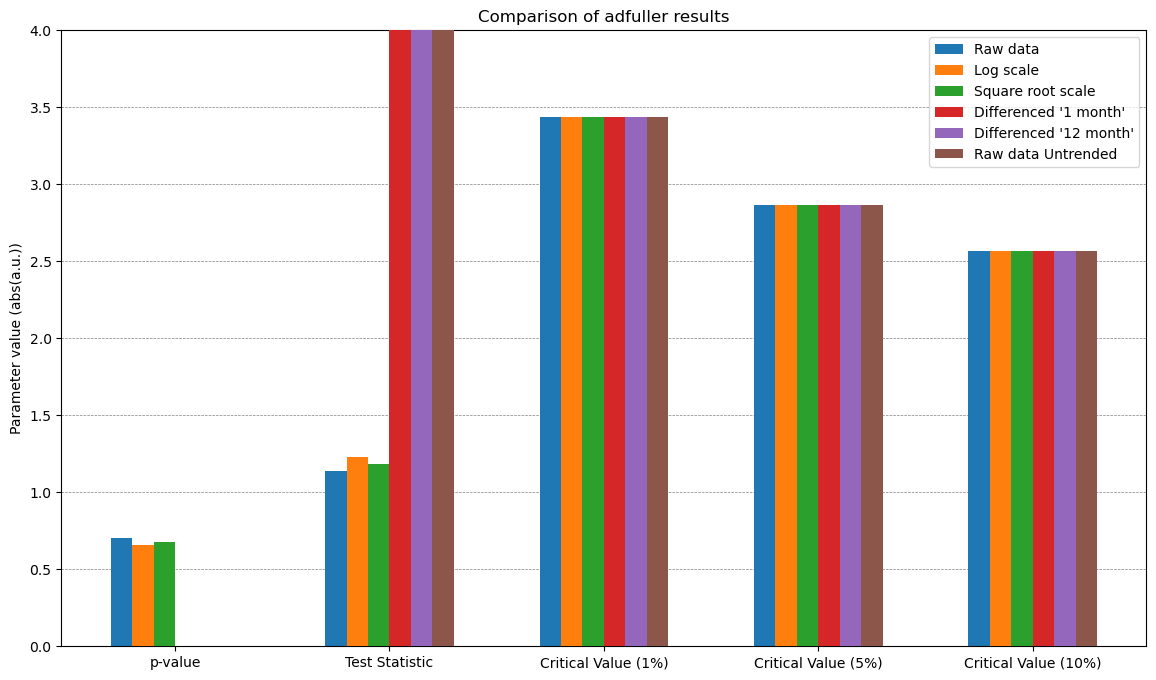

In [390]:
X = ['p-value','Test Statistic','Critical Value (1%)','Critical Value (5%)','Critical Value (10%)']

rawdata_barplot = np.absolute(adfuller_result_rawdata[X]).tolist()
logscale_barplot = np.absolute(adfuller_result_logscale[X]).tolist()
sqrt_barplot = np.absolute(adfuller_result_sqrt[X]).tolist()
diff_barplot = np.absolute(adfuller_result_diff[X]).tolist()
diff_year_barplot = np.absolute(adfuller_result_diff_year[X]).tolist()
untrended_barplot = np.absolute(adfuller_result_untrended[X]).tolist()


X_axis = np.arange(len(X))
width = 0.1

plt.figure(figsize=(14,8))
plt.bar(X_axis, rawdata_barplot, width, label = 'Raw data', zorder=2)
plt.bar(X_axis + width, logscale_barplot, width, label = 'Log scale', zorder=3)
plt.bar(X_axis + width*2, sqrt_barplot, width, label = 'Square root scale', zorder=4)
plt.bar(X_axis + width*3, diff_barplot, width, label = 'Differenced \'1 month\'',  zorder=5)
plt.bar(X_axis + width*4, diff_barplot, width, label = 'Differenced \'12 month\'', zorder=6)
plt.bar(X_axis + width*5, untrended_barplot, width, label = 'Raw data Untrended',  zorder=7)
plt.xticks(X_axis, X)
plt.ylabel("Parameter value (abs(a.u.))")
plt.title("Comparison of adfuller results")
plt.xticks(X_axis+width*2.5,X)
plt.ylim([0,4])
plt.grid(axis='y',color='gray', linestyle='dashed', linewidth=0.5, zorder=1)
plt.legend()
plt.show()

From the above graph we can clearly observe that the only stationnary datasets are the differenced and untrended transformations. As their p-values are close to 0 and since their Test statistic are close to critical values

In [392]:
decomposed_temperature = seasonal_decompose(data_temperature_ts, model='additive')

In [393]:
data_temperature_residual = decomposed_temperature.resid.dropna()

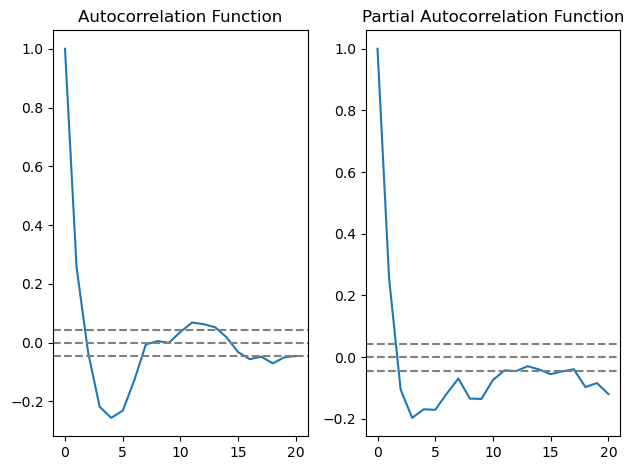

In [394]:
#ACF & PACF plots

lag_acf = acf(data_temperature_residual, nlags=20)
lag_pacf = pacf(data_temperature_residual, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_temperature_residual)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_temperature_residual)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_temperature_residual)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_temperature_residual)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()    

In [395]:
data_temperature_residual.index.freq = 'MS'
model_fit = ARIMA(data_temperature_residual, order=(3,0,3)).fit(method_kwargs={"warn_convergence": True, 'maxiter':100})
forecast = model_fit.get_forecast(steps=35*12)
forecasts_and_intervals = forecast.summary_frame(alpha=0.05)

In [396]:
forecasts_and_intervals["mean"]

2015-07-01   -0.008288
2015-08-01    0.004062
2015-09-01    0.010722
2015-10-01    0.012812
2015-11-01    0.010646
                ...   
2050-02-01   -0.000009
2050-03-01   -0.000009
2050-04-01   -0.000009
2050-05-01   -0.000009
2050-06-01   -0.000009
Freq: MS, Name: mean, Length: 420, dtype: float64

In [397]:
model_fit.predict(start='1850', end='2050')

1850-07-01   -0.000009
1850-08-01    0.055750
1850-09-01    0.048133
1850-10-01   -0.043059
1850-11-01   -0.105519
                ...   
2049-09-01   -0.000009
2049-10-01   -0.000009
2049-11-01   -0.000009
2049-12-01   -0.000009
2050-01-01   -0.000009
Freq: MS, Name: predicted_mean, Length: 2395, dtype: float64

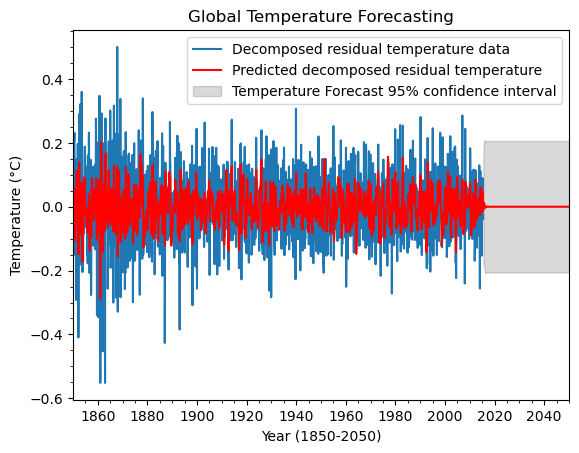

In [398]:
plt.plot(decomposed_temperature.resid, label='Decomposed residual temperature data')
plt.plot(model_fit.predict(start='1850', end='2050'), color='r', label='Predicted decomposed residual temperature')
# plt.plot(forecasts_and_intervals["mean"], color='k', label='Forecast of decomposed residual temperature')
plt.fill_between(forecasts_and_intervals.index, forecasts_and_intervals["mean_ci_lower"], forecasts_and_intervals["mean_ci_upper"], label='Temperature Forecast 95% confidence interval',color='k', alpha=.15)
plt.xlim([datetime.date(1850, 1, 1), datetime.date(2050, 1, 12)])
plt.ylabel('Temperature (°C)')
plt.xlabel('Year (1850-2050)')
plt.title('Global Temperature Forecasting')
plt.legend(loc='best', fontsize=10)
plt.minorticks_on()
plt.show()

On the graph above we see

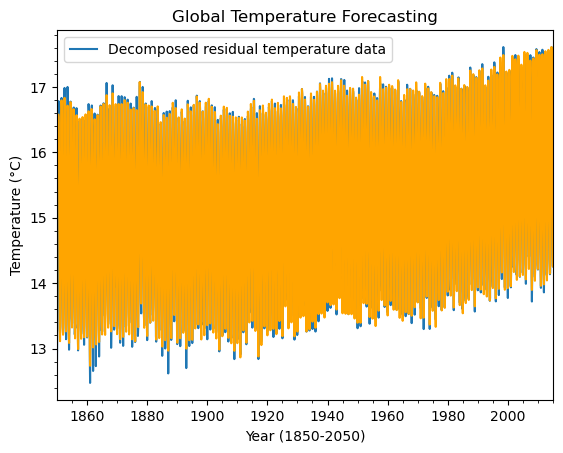

In [399]:
plt.plot(decomposed_temperature.observed, label = 'Decomposed residual temperature data')
plt.plot(decomposed_temperature.trend + decomposed_temperature.seasonal + model_fit.predict(start='1850', end='2015'), color='orange')
plt.xlim([datetime.date(1850, 1, 1), datetime.date(2015, 1, 12)])
plt.ylabel('Temperature (°C)')
plt.xlabel('Year (1850-2050)')
plt.title('Global Temperature Forecasting')
plt.legend(loc='best', fontsize=10)
plt.minorticks_on()
plt.show()

In [400]:
auto_arima_yearly = pm.auto_arima(data_temperature_ts, stepwise=True, seasonal=True, with_intercept=False)
auto_arima_yearly

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

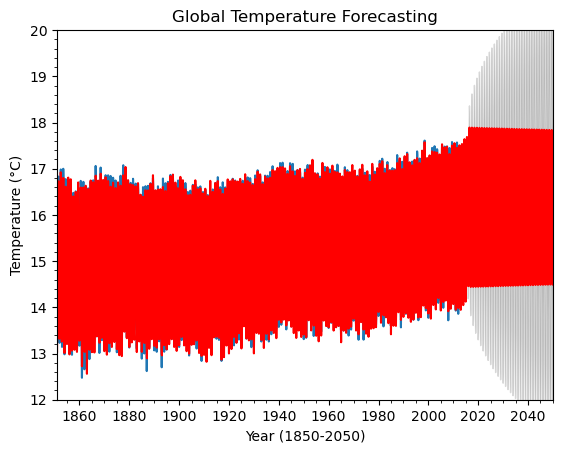

In [401]:
data_temperature_ts.index.freq = 'MS'
model_fit_raw = ARIMA(data_temperature_ts, order=(4,1,2), seasonal_order=(0, 0, 0, 0)).fit(method_kwargs={"warn_convergence": True, 'maxiter':300})
forecast_raw = model_fit_raw.get_forecast(steps=35*12)
forecasts_and_intervals_raw = forecast_raw.summary_frame(alpha=0.05)

plt.plot(data_temperature_ts, label='Decomposed residual temperature data')
plt.plot(model_fit_raw.predict(start='1850', end='2050'), color='r', label='Predicted decomposed residual temperature')
# plt.plot(forecasts_and_intervals["mean"], color='k', label='Forecast of decomposed residual temperature')
plt.fill_between(forecasts_and_intervals_raw.index, forecasts_and_intervals_raw["mean_ci_lower"], forecasts_and_intervals_raw["mean_ci_upper"], label='Temperature Forecast 95% confidence interval',color='k', alpha=.15)
plt.xlim([datetime.date(1851, 1, 1), datetime.date(2050, 1, 12)])
plt.ylim([12,20])
plt.ylabel('Temperature (°C)')
plt.xlabel('Year (1850-2050)')
plt.title('Global Temperature Forecasting')
# plt.legend(loc='best', fontsize=10)
plt.minorticks_on()
plt.show()

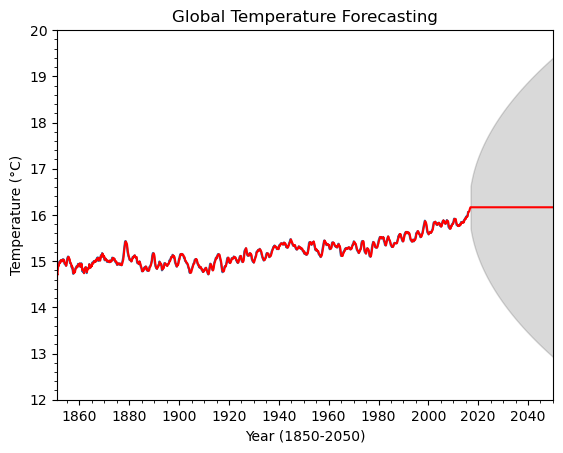

In [402]:
plt.plot(data_temperature_ts.rolling(window=12).mean(), label='Decomposed residual temperature data')
plt.plot(model_fit_raw.predict(start='1850', end='2050').rolling(window=12).mean(), color='r', label='Predicted decomposed residual temperature')
# plt.plot(forecasts_and_intervals["mean"], color='k', label='Forecast of decomposed residual temperature')
plt.fill_between(forecasts_and_intervals_raw.index, forecasts_and_intervals_raw["mean_ci_lower"].rolling(window=12).mean(), forecasts_and_intervals_raw["mean_ci_upper"].rolling(window=12).mean(), label='Temperature Forecast 95% confidence interval',color='k', alpha=.15)
plt.xlim([datetime.date(1851, 1, 1), datetime.date(2050, 1, 12)])
plt.ylim([12,20])
plt.ylabel('Temperature (°C)')
plt.xlabel('Year (1850-2050)')
plt.title('Global Temperature Forecasting')
# plt.legend(loc='best', fontsize=10)
plt.minorticks_on()
plt.show()

#### Time series forecasting: with yearly averages 

In [403]:
data_global_yearly_temperatures

,Year,YearlyLandAverageTemperature,YearlyLandAverageTemperatureUncertainty,YearlyLandMaxTemperature,YearlyLandMaxTemperatureUncertainty,YearlyLandMinTemperature,YearlyLandMinTemperatureUncertainty,YearlyLandAndOceanAverageTemperature,YearlyLandAndOceanAverageTemperatureUncertainty,YearlyOceanAverageTemperature,YearlyOceanAverageTemperatureUncertainty
1750,1750,8.719364,2.637818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1751,1751,7.976143,2.781143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1752,5.779833,2.977000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1753,1753,8.388083,3.176000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1754,1754,8.469333,3.494250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2011,2011,9.516000,0.082000,15.284833,0.114333,3.827667,0.136583,15.769500,0.059000,6.253500,0.141000
2012,2012,9.507333,0.083417,15.332833,0.107333,3.756167,0.145333,15.802333,0.061500,6.295000,0.144917
2013,2013,9.606500,0.097667,15.373833,0.115500,3.911333,0.149833,15.854417,0.064667,6.247917,0.162333
2014,2014,9.570667,0.090167,15.313583,0.111667,3.877750,0.139000,15.913000,0.063167,6.342333,0.153333


In [404]:
data_global_yearly_temperatures.loc[1900:,['Year','YearlyLandAndOceanAverageTemperature']]

,Year,YearlyLandAndOceanAverageTemperature
1900,1900,15.143917
1901,1901,15.073333
1902,1902,14.958333
1903,1903,14.836583
1904,1904,14.810417
...,...,...
2011,2011,15.769500
2012,2012,15.802333
2013,2013,15.854417
2014,2014,15.913000


In [405]:
pd.to_datetime(ts['dt'][1800:])

1800   1900-01-01
1801   1900-02-01
1802   1900-03-01
1803   1900-04-01
1804   1900-05-01
          ...    
3187   2015-08-01
3188   2015-09-01
3189   2015-10-01
3190   2015-11-01
3191   2015-12-01
Name: dt, Length: 1392, dtype: datetime64[ns]

In [406]:
data_global_yearly_temperatures.loc[1900:,['Year','YearlyLandAndOceanAverageTemperature']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 1900 to 2015
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Year                                  116 non-null    int64  
 1   YearlyLandAndOceanAverageTemperature  116 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.7 KB


In [407]:
pd.to_datetime(ts['dt'][1800:])

1800   1900-01-01
1801   1900-02-01
1802   1900-03-01
1803   1900-04-01
1804   1900-05-01
          ...    
3187   2015-08-01
3188   2015-09-01
3189   2015-10-01
3190   2015-11-01
3191   2015-12-01
Name: dt, Length: 1392, dtype: datetime64[ns]

In [408]:
data_yearly_temperature_ts = pd.Series(data_global_yearly_temperatures.loc[1850:,'YearlyLandAndOceanAverageTemperature'].values, index = pd.to_datetime(data_global_yearly_temperatures.loc[1850:,'Year'], format='%Y'))
data_yearly_temperature_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 166 entries, 1850-01-01 to 2015-01-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
166 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


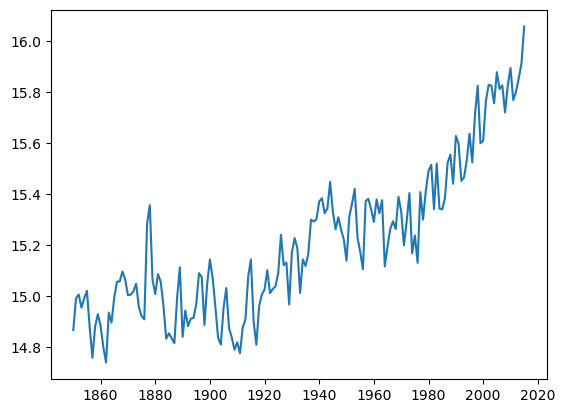

In [409]:
plt.plot(data_yearly_temperature_ts)
plt.show()

In [410]:
adfuller_critical_values(data_yearly_temperature_ts)

Test Statistic                   1.130564
p-value                          0.995469
#Lags Used                       9.000000
Number of Observations Used    156.000000
Critical Value (1%)             -3.472979
Critical Value (5%)             -2.880252
Critical Value (10%)            -2.576747
dtype: float64

In [411]:
auto_arima_yearly = pm.auto_arima(data_yearly_temperature_ts, stepwise=True, seasonal=True)
auto_arima_yearly

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True)

In [412]:
data_yearly_temperature_ts

Year
1850-01-01    14.867167
1851-01-01    14.991833
1852-01-01    15.006500
1853-01-01    14.955167
1854-01-01    14.991000
                ...    
2011-01-01    15.769500
2012-01-01    15.802333
2013-01-01    15.854417
2014-01-01    15.913000
2015-01-01    16.058583
Length: 166, dtype: float64

In [413]:
data_yearly_temperature_ts.index.freq = 'AS-JAN'

In [539]:
model_fit_y = ARIMA(data_yearly_temperature_ts, order=(1,1,3)).fit()
forecast_y = model_fit_y.get_forecast(steps=35)
forecasts_and_intervals_y = forecast_y.summary_frame(alpha=0.05)

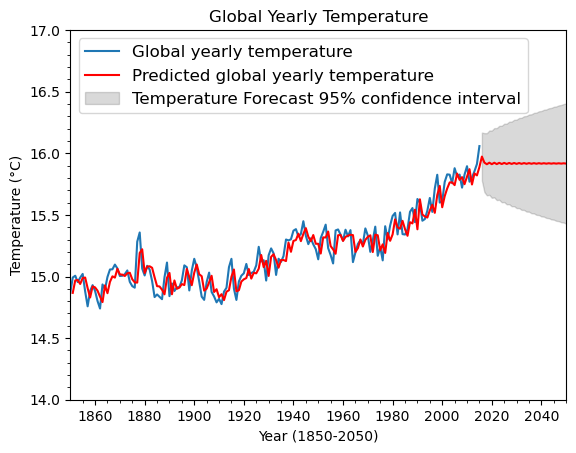

In [542]:
plt.plot(data_yearly_temperature_ts, label='Global yearly temperature')
plt.plot(model_fit_y.predict(start='1851', end='2050'), color='r', label='Predicted global yearly temperature')
plt.fill_between(forecasts_and_intervals_y.index, forecasts_and_intervals_y["mean_ci_lower"], forecasts_and_intervals_y["mean_ci_upper"], color='k', alpha=.15, label='Temperature Forecast 95% confidence interval')
plt.xlim([datetime.date(1850, 1, 1), datetime.date(2050, 1, 12)])
plt.ylabel('Temperature (°C)')
plt.xlabel('Year (1850-2050)')
plt.title('Global Yearly Temperature')
plt.legend(loc='upper left', fontsize=12)
plt.ylim([14,17])
plt.minorticks_on()
plt.show()

What are the confidence intervalls plotted above ? first stands for alpha = 0.05 and the second to alpha = 0.15. How do they relate to the sigma values and to 95-99% ? 

#### New attempt to use ARIMA model for the Yearly forecast

In [505]:
ARIMA_model = pm.auto_arima(data_yearly_temperature_ts,
    start_p=1, start_q=1,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=False, #set to seasonal
    d=None, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-279.409, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-252.541, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-256.118, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-267.815, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-253.846, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-265.211, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-280.386, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-281.854, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-280.978, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-285.790, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-280.999, Time=0.11 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-283.679, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-282.634, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-279.828, Time=0.11 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

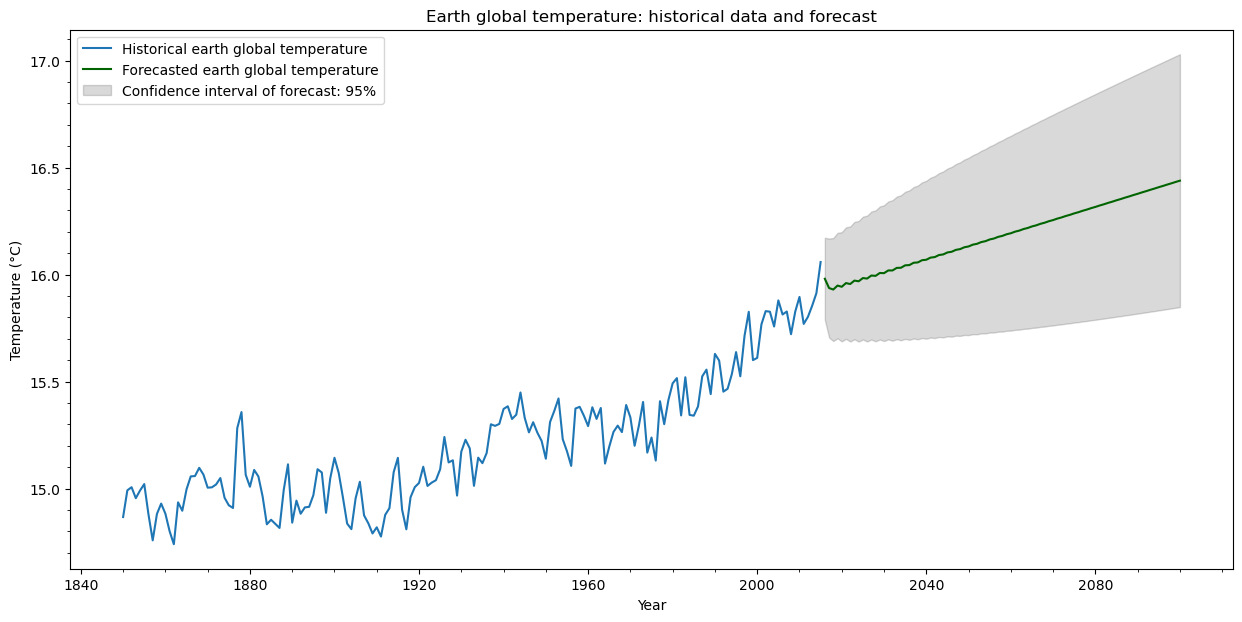

In [545]:
model_forecast_plot(ARIMA_model, data_yearly_temperature_ts, 85)

## Machine learning forecasting of the time series

In [416]:
data_yearly_temperature_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 166 entries, 1850-01-01 to 2015-01-01
Freq: AS-JAN
Series name: None
Non-Null Count  Dtype  
--------------  -----  
166 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


In [417]:
X = data_global_yearly_temperatures.loc[1850:,'Year'].values.reshape(-1,1)
y = data_yearly_temperature_ts.values

In [418]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(X, y)

In [419]:
y_pred = pd.Series(lin_reg.predict(X), index=data_global_yearly_temperatures.loc[1850:,'Year'].values)

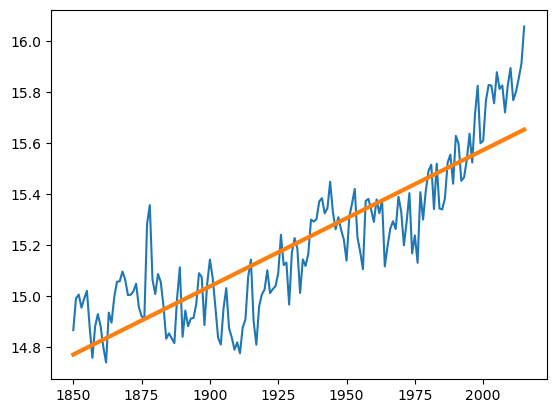

In [420]:
plt.plot(X,y)
plt.plot(y_pred,linewidth=3)
plt.show()

In [421]:
X_forecast = np.array(range(2016,2050)).reshape(-1,1)
y_forecast =  pd.Series(lin_reg.predict(X_forecast), index=np.array(range(2016,2050)))

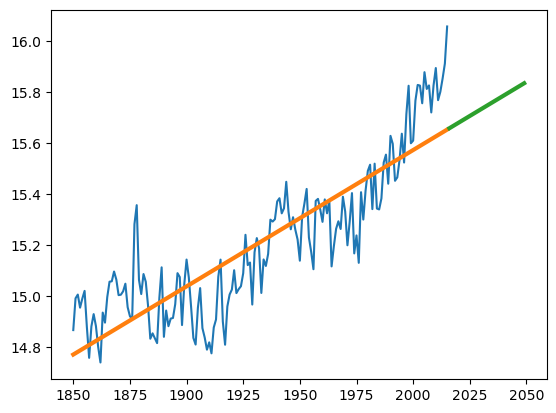

In [422]:
plt.plot(X,y)
plt.plot(y_pred,linewidth=3)
plt.plot(X_forecast,y_forecast,linewidth=3)
plt.show()

In [423]:
data_global_yearly_temperatures

,Year,YearlyLandAverageTemperature,YearlyLandAverageTemperatureUncertainty,YearlyLandMaxTemperature,YearlyLandMaxTemperatureUncertainty,YearlyLandMinTemperature,YearlyLandMinTemperatureUncertainty,YearlyLandAndOceanAverageTemperature,YearlyLandAndOceanAverageTemperatureUncertainty,YearlyOceanAverageTemperature,YearlyOceanAverageTemperatureUncertainty
1750,1750,8.719364,2.637818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1751,1751,7.976143,2.781143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1752,5.779833,2.977000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1753,1753,8.388083,3.176000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1754,1754,8.469333,3.494250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2011,2011,9.516000,0.082000,15.284833,0.114333,3.827667,0.136583,15.769500,0.059000,6.253500,0.141000
2012,2012,9.507333,0.083417,15.332833,0.107333,3.756167,0.145333,15.802333,0.061500,6.295000,0.144917
2013,2013,9.606500,0.097667,15.373833,0.115500,3.911333,0.149833,15.854417,0.064667,6.247917,0.162333
2014,2014,9.570667,0.090167,15.313583,0.111667,3.877750,0.139000,15.913000,0.063167,6.342333,0.153333


In [424]:
data_global_yearly_temperatures.loc[1850:,['Year','YearlyLandAndOceanAverageTemperature']]

,Year,YearlyLandAndOceanAverageTemperature
1850,1850,14.867167
1851,1851,14.991833
1852,1852,15.006500
1853,1853,14.955167
1854,1854,14.991000
...,...,...
2011,2011,15.769500
2012,2012,15.802333
2013,2013,15.854417
2014,2014,15.913000


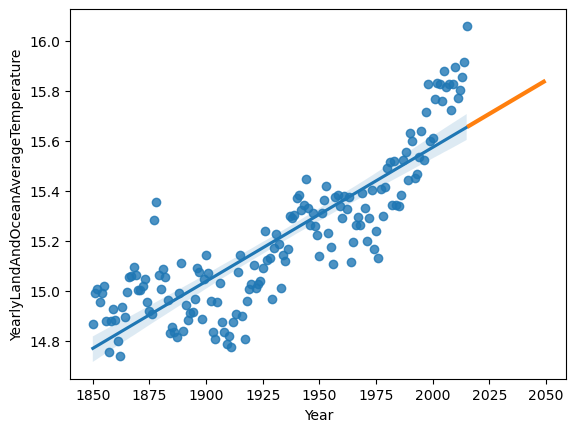

In [425]:
sns.regplot(x ='Year', y ='YearlyLandAndOceanAverageTemperature', data = data_global_yearly_temperatures.loc[1850:,['Year','YearlyLandAndOceanAverageTemperature']], ci = 95, scatter = True, fit_reg=True)
plt.plot(X_forecast,y_forecast,linewidth=3,  label = 'Linear regression forecast')

plt.show()

In [426]:
data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[1850:].values

array([14.86716667, 14.99183333, 15.0065    , 14.95516667, 14.991     ,
       15.02108333, 14.87933333, 14.75825   , 14.8815    , 14.92991667,
       14.88291667, 14.80066667, 14.74008333, 14.93575   , 14.8965    ,
       14.99666667, 15.057     , 15.05866667, 15.09691667, 15.0655    ,
       15.00433333, 15.00591667, 15.01933333, 15.04925   , 14.957     ,
       14.92191667, 14.90941667, 15.28266667, 15.35741667, 15.06441667,
       15.00866667, 15.08716667, 15.05658333, 14.96325   , 14.83325   ,
       14.85441667, 14.83525   , 14.816     , 14.99408333, 15.11341667,
       14.84075   , 14.94383333, 14.8825    , 14.91225   , 14.91475   ,
       14.969     , 15.09058333, 15.07533333, 14.88691667, 15.04833333,
       15.14391667, 15.07333333, 14.95833333, 14.83658333, 14.81041667,
       14.95466667, 15.03191667, 14.87483333, 14.83816667, 14.79033333,
       14.81908333, 14.776     , 14.87716667, 14.90875   , 15.07625   ,
       15.14375   , 14.90133333, 14.80975   , 14.95983333, 15.00

In [427]:
from scipy.stats import linregress

In [428]:
data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[1850:] - 10

1850    4.867167
1851    4.991833
1852    5.006500
1853    4.955167
1854    4.991000
          ...   
2011    5.769500
2012    5.802333
2013    5.854417
2014    5.913000
2015    6.058583
Name: YearlyLandAndOceanAverageTemperature, Length: 166, dtype: float64

In [429]:
slope, intercept, r_value, p_value, std_err = linregress(
        x = data_global_yearly_temperatures['Year'].loc[1850:].values,
        y = data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[1850:].values
)

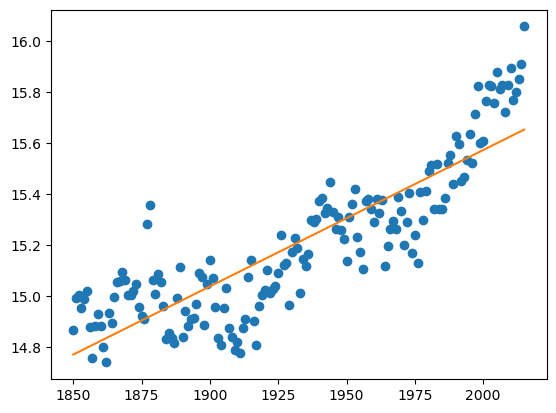

In [430]:
x_values = data_global_yearly_temperatures['Year'].loc[1850:].values
y_values = data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[1850:].values
plt.plot(x_values, y_values, 'o')
plt.plot(x_values, slope * x_values + intercept)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     470.4
Date:                Sat, 03 Jun 2023   Prob (F-statistic):           4.82e-50
Time:                        20:01:21   Log-Likelihood:                 77.858
No. Observations:                 166   AIC:                            -151.7
Df Residuals:                     164   BIC:                            -145.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8736      0.477     10.220      0.0

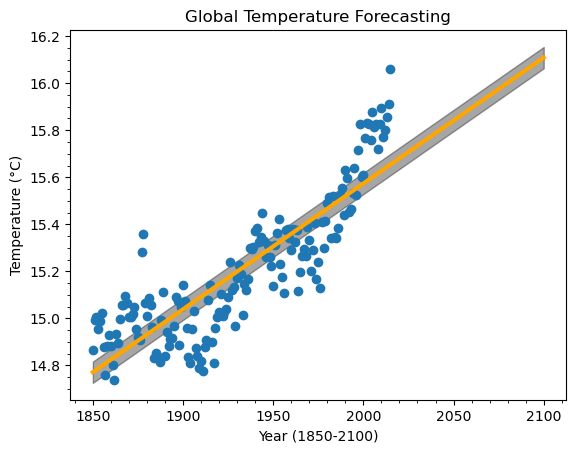

In [431]:
import statsmodels.api as sm

x_values_extrapolated = np.array(range(1850,2101))
results = sm.OLS(y_values,sm.add_constant(x_values)).fit()

confidence_interval = st.norm.interval(confidence=0.95, loc=np.mean(y_values), scale=st.sem(y_values))
confidence_95_pourcent = np.mean(y_values) - confidence_interval[0]

print(results.summary())

plt.scatter(x_values,y_values, zorder=2)
plt.plot(x_values_extrapolated, x_values_extrapolated * results.params[1] + results.params[0], color = 'orange', zorder=3, linewidth=3)
plt.fill_between(x_values_extrapolated, x_values_extrapolated * results.params[1] + results.params[0] - confidence_95_pourcent, x_values_extrapolated * results.params[1] + results.params[0] + confidence_95_pourcent, color='k', alpha=.35, label='Temperature Forecast 99% confidence interval',zorder=1)
plt.minorticks_on()
plt.ylabel('Temperature (°C)')
plt.xlabel('Year (1850-2100)')
plt.title('Global Temperature Forecasting')
plt.show()

### Add a vertical line at 2015 to separate the existing data adn the forecasted region (maybe add a light background color)

Try reproducing the same graph using simple matplotlib scatter, will require confidence interval calculus. Add confidence interval to the linear regression plot. Why our ARIMA time series forecasting doesn't simulate the trend of the temperature curve ? probably something is "off" in the seasonal parameters and by using SARIMA or SARIMAX we can reproduce the trend of the raw data plot.